# Azure AI Search with Azure AI Vision multimodal embeddings for text-to-image queries

As a scenario, this code shows you an approach for text-to-image vector queries. As a technical sample, it demonstrates how to call a custom embedding model for situations where you want models other an Azure OpenAI or OpenAI for vectorization. The multimodal embeddings used in this sample are provided by [Azure AI Vision 4.0](https://learn.microsoft.com/azure/ai-services/computer-vision/how-to/image-retrieval) and the [Image Retrieval REST API](https://learn.microsoft.com/rest/api/computervision/image-retrieval) which supports built-in vectorization of images. 

For indexing, the pattern uses a custom skill to wrap an Azure function app used to call the Image Retrieval API. Provisioning of this function app and custom skill is fully automated and included as a step in this notebook.

The function app is also used during queries, as the vectorizer. A vectorizer specifies which embedding model to use for vectorizing a text query string. As always, it's strongly recommended that query vectorization is performed using the same embedding model used for document vectorization during indexing.

### Prerequisites

+ [Azure AI Search](https://learn.microsoft.com/azure/search/search-create-service-portal), any region and tier, but we recommend Basic or higher for this workload.

+ [Azure Blob storage](https://learn.microsoft.com/azure/storage/common/storage-account-create), used as the data source during indexing.

+ [azd](https://learn.microsoft.com/azure/developer/azure-developer-cli/install-azd), used to deploy an Azure function app and Azure AI Vision in your Azure subscription.

We use the [Azure Python SDK](https://learn.microsoft.com/en-us/python/api/azure-search-documents/?view=azure-python-preview) for indexer-driven indexing and vector query operations.

### Set up a Python virtual environment in Visual Studio Code

1. Open the Command Palette (Ctrl+Shift+P).
1. Search for **Python: Create Environment**.
1. Select **Venv**.
1. Select a Python interpreter. Choose 3.10 or later.

It can take a minute to set up. If you run into problems, see [Python environments in VS Code](https://code.visualstudio.com/docs/python/environments).

### Install packages

In [2]:
! pip install -r requirements.txt --quiet


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Load .env file

Copy `.env-sample` to an `.env` file in the sample folder, and update accordingly. The search service and Azure Storage account must exist, but the search index and blob container are created and loaded during code execution. Provide unique names for both the index and container. Endpoint, API key, and connection string can be found in the Azure portal.

In [3]:
from dotenv import load_dotenv
from azure.identity import DefaultAzureCredential
from azure.core.credentials import AzureKeyCredential
import os

load_dotenv(override=True) # take environment variables from .env.

# Variables not used here do not need to be updated in your .env file
endpoint = os.environ["AZURE_SEARCH_SERVICE_ENDPOINT"]
credential = AzureKeyCredential(os.environ["AZURE_SEARCH_ADMIN_KEY"]) if len(os.environ["AZURE_SEARCH_ADMIN_KEY"]) > 0 else DefaultAzureCredential()
index_name = os.environ["AZURE_SEARCH_INDEX"]
blob_connection_string = os.environ["BLOB_CONNECTION_STRING"]
blob_container_name = os.environ["BLOB_CONTAINER_NAME"]

### Provision a custom skill

This sample uses [`azd`](https://learn.microsoft.com/azure/developer/azure-developer-cli/) and a bicep template to deploy an Azure function.

1. Open a PowerShell command prompt in the custom-skills folder.

1. Run `azd config set defaults.subscription <yourSubscriptionID>` to set the subscription if you have multiple Azure subscriptions.
1. Run `azd up`.

   1. Enter a development environment name.
   1. Enter a region for the function app. Choose a region that provides the Image Retrieval API: `East US`, `France Central`, `Korea Central`, `North Europe`, `Southeast Asia`, `West Europe`, `West US`.

If you aren't prompted for an environment or region, retry `azd up -e` to specify a new environment and region.

This step takes several minutes to complete.

### Retrieve azd environment variables after provisioning

In [7]:
import subprocess
from io import StringIO
from dotenv import load_dotenv
import os

# Print current working directory for debugging
print("Current working directory:", os.getcwd())

try:
    result = subprocess.run("azd env get-values", stdout=subprocess.PIPE, stderr=subprocess.PIPE, cwd=os.getcwd(), shell=True, text=True)
    print("Subprocess return code:", result.returncode)
    if result.returncode == 0:
        load_dotenv(override=True, stream=StringIO(result.stdout))
    else:
        print("Error:", result.stderr)
except Exception as e:
    print("Exception occurred:", e)


Current working directory: /Users/dhawansolanki/BigBuddy/imagesearch
Subprocess return code: 0


### Get custom skill connection string

In [8]:
from azure.identity import DefaultAzureCredential
from azure.mgmt.web import WebSiteManagementClient

subscription_id = os.environ["AZURE_SUBSCRIPTION_ID"]
client = WebSiteManagementClient(credential=DefaultAzureCredential(), subscription_id=subscription_id)

resource_group = os.environ["AZURE_APP_SERVICE_PLAN_RESOURCE_GROUP"]
function_app_name = os.environ["AZURE_FUNCTION_APP_NAME"]
function_name = "GetImageEmbedding"
embedding_function = client.web_apps.get_function(resource_group_name=resource_group, name=function_app_name, function_name=function_name)
embedding_function_keys = client.web_apps.list_function_keys(resource_group_name=resource_group, name=function_app_name, function_name=function_name)
function_url_template = embedding_function.invoke_url_template
function_key = embedding_function_keys.additional_properties["default"]
function_app_url=f"{function_url_template}?code={function_key}"

### Upload image to Blob storage

This step pulls sample image files from the local data/images folder. It uploads the images to an Azure storage account and container name specified as an envrionment variable. This code creates the container and uploads the images.

In [10]:
from azure.storage.blob import BlobServiceClient

# Connect to Blob Storage
blob_service_client = BlobServiceClient.from_connection_string(blob_connection_string)
container_client = blob_service_client.get_container_client(blob_container_name)
if not container_client.exists():
    container_client.create_container()

apples_image_directory = os.path.join('data', 'images', 'apples')
for image_name in os.listdir(apples_image_directory):
    if image_name.endswith(".jpeg"):
        image_path = os.path.join(apples_image_directory, image_name)
        if not container_client.get_blob_client(image_name).exists():
            with open(image_path, "rb") as data:
                container_client.upload_blob(name=image_name, data=data)

print("Uploaded sample images")

Uploaded sample images


### Create a blob data source on Azure AI Search

In [11]:
from azure.search.documents.indexes import SearchIndexerClient
from azure.search.documents.indexes.models import SearchIndexerDataContainer, SearchIndexerDataSourceConnection
# Create a data source 
ds_client = SearchIndexerClient(endpoint, credential)
container = SearchIndexerDataContainer(name=blob_container_name)
data_source_connection = SearchIndexerDataSourceConnection(
    name=f"{index_name}-blob",
    type="azureblob",
    connection_string=blob_connection_string,
    container=container
)
data_source = ds_client.create_or_update_data_source_connection(data_source_connection)

print(f"Data source '{data_source.name}' created or updated")

Data source 'aisearch-index-blob' created or updated


### Create a skillset

The skillset specifies the custom skill used during indexing to vectorize images in the blob container. The `uri` specifies the function app you deployed earlier using `azd`.

In [12]:
from azure.search.documents.indexes.models import (
    WebApiSkill,
    InputFieldMappingEntry,
    OutputFieldMappingEntry,
    SearchIndexerSkillset
)

# Create a skillset  
skillset_name = f"{index_name}-skillset"  
  
skill = WebApiSkill(  
    description="Skill to generate image embeddings via a custom endpoint",  
    context="/document",
    http_method="POST",
    batch_size=10, # Controls how many images are sent to the custom skill at a time
    uri=function_app_url,
    inputs=[
        InputFieldMappingEntry(name="imageUrl", source="/document/metadata_storage_path"),
        InputFieldMappingEntry(name="sasToken", source="/document/metadata_storage_sas_token"),  
    ],  
    outputs=[  
        OutputFieldMappingEntry(name="vector", target_name="vector")
    ],
)
  
skillset = SearchIndexerSkillset(  
    name=skillset_name,  
    description="Skillset to extract image vector",  
    skills=[skill],  
)
  
ds_client.create_or_update_skillset(skillset)  
print(f'Skillset {skillset.name} created')  


Skillset aisearch-index-skillset created


### Create an index
Create your search index schema and vector search configuration. Here, the function app is used again in the vectorizer definition. It's used for text-to-image queries.

In [14]:
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    SimpleField,
    SearchFieldDataType,
    SearchField,
    VectorSearch,
    HnswAlgorithmConfiguration,
    VectorSearchProfile,
    SearchIndex,
    CustomVectorizer,
    CustomWebApiParameters
)

# Create a search index  
index_client = SearchIndexClient(endpoint=endpoint, credential=credential)  
fields = [  
    SimpleField(name="id", type=SearchFieldDataType.String, key=True, sortable=True, filterable=True, facetable=True),  
    SearchField(name="imageUrl", type=SearchFieldDataType.String),  
    SearchField(name="title", type=SearchFieldDataType.String),  
    SearchField(  
        name="imageVector",  
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single),  
        vector_search_dimensions=1024,  
        vector_search_profile_name="myHnswProfile",  
    ),  
]  
  
# Configure the vector search configuration  
vector_search = VectorSearch(  
    algorithms=[  
        HnswAlgorithmConfiguration(  
            name="myHnsw"
        )
    ],  
   profiles=[  
        VectorSearchProfile(  
            name="myHnswProfile",  
            algorithm_configuration_name="myHnsw", 
            vectorizer="customVectorizer"
        )
    ],
    vectorizers=[  
        CustomVectorizer(name="customVectorizer", custom_web_api_parameters=CustomWebApiParameters(uri=function_app_url))
    ]
)
  
# Create the search index with the vector search configuration  
index = SearchIndex(name=index_name, fields=fields, vector_search=vector_search)  
result = index_client.create_or_update_index(index)  
print(f"{result.name} created")  


aisearch-index created


### Create an indexer

Create or update an indexer to process images and populate the search index

In [15]:
from azure.search.documents.indexes.models import (
    SearchIndexer,
    FieldMapping
)

# Create an indexer  
indexer_name = f"{index_name}-indexer"  
indexer = SearchIndexer(  
    name=indexer_name,  
    description="Indexer to process images",  
    skillset_name=skillset_name,  
    target_index_name=index_name,  
    data_source_name=data_source.name,  
    field_mappings=[  
        FieldMapping(source_field_name="metadata_storage_path", target_field_name="imageUrl"),  
        FieldMapping(source_field_name="metadata_storage_name", target_field_name="title")  
    ],  
    output_field_mappings=[  
        FieldMapping(source_field_name="/document/vector", target_field_name="imageVector")  
    ]  
)  
  
indexer_client = SearchIndexerClient(endpoint, credential)  
indexer_result = indexer_client.create_or_update_indexer(indexer)  
  
# Run the indexer  
indexer_client.run_indexer(indexer_name)  
print(f'{indexer_name} is created and running. It will be several minutes before you can run the queries.')

aisearch-index-indexer is created and running. It will be several minutes before you can run the queries.


### Perform a vector search by vectorizing your text query

Perform a vector search to find the most relevant images based on the text query.

Vector queries call [VectorizableTextQuery](https://learn.microsoft.com/python/api/azure-search-documents/azure.search.documents.models.vectorizabletextquery) to vectorize a query text string that's used to match against vectorized images created by the custom skill. VectorizeableTextQuery uses the vectorizer defined in the index, which is the function app that runs Azure AI Vision image retrieval.

Title: image_0003.jpeg
Image URL: https://aisearchmagicroll.blob.core.windows.net/aisearch/image_0003.jpeg


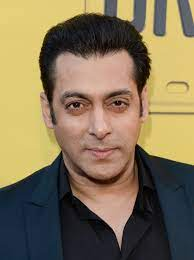

In [29]:
from azure.search.documents import SearchClient
from azure.search.documents.models import (
    VectorizableTextQuery
)
from IPython.display import Image

apples_image_directory = os.path.join('data', 'images', 'apples')
# Generate text embeddings for the query  
query = "green apple"  
  
# Initialize the SearchClient  
search_client = SearchClient(endpoint, index_name, credential)  
vector_query = VectorizableTextQuery(text=query, k_nearest_neighbors=1, fields="imageVector")  

# Perform vector search  
results = search_client.search(  
    search_text=None,  
    vector_queries= [vector_query],
    select=["title", "imageUrl"],
    top=1
)   
  
# Print the search results  
for result in results:  
    print(f"Title: {result['title']}")  
    print(f"Image URL: {result['imageUrl']}") 
    display(Image(filename=os.path.join(apples_image_directory, os.path.basename(result['imageUrl'])))) 
    print("\n") 


Perform a vector search to find the most relevant images based on the image query

In [33]:
import requests

# Generate image embeddings for the query (for context, this is a photo of a red apple)
query = "https://upload.wikimedia.org/wikipedia/commons/a/a6/Pink_lady_and_cross_section.jpg"

response = requests.post(function_app_url, json={ "values": [ { "recordId": 0, "data": { "imageUrl": query, "sasToken": "" } } ] })  
response.raise_for_status()
vector = response.json()["values"][0]["data"]["vector"]

Source Image


Title: image_0002.jpeg
Image URL: https://aisearchmagicroll.blob.core.windows.net/aisearch/image_0002.jpeg


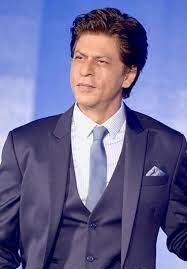

In [34]:
from azure.search.documents.models import VectorizedQuery

# Initialize the SearchClient  
search_client = SearchClient(endpoint, index_name, credential)  
vector_query = VectorizedQuery(vector=vector, k_nearest_neighbors=1, fields="imageVector")  

# Perform vector search  
results = search_client.search(  
    search_text=None,  
    vector_queries= [vector_query],
    select=["title", "imageUrl"],
    top=1
)   

print("Source Image")
display(Image(url=query))
# Print the search results  
for result in results:  
    print(f"Title: {result['title']}")  
    print(f"Image URL: {result['imageUrl']}") 
    display(Image(filename=os.path.join(apples_image_directory, os.path.basename(result['imageUrl'])))) 
    print("\n") 